In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout, Input
from tqdm import tqdm
import time
from cond_rnn import ConditionalRNN
import json
import tensorflow as tf

function for calculating *Symmetric Mean Absolute Percentage Error*.

In [3]:
def smape(predictions, actual):
    difference = np.abs(predictions-actual)
    summation = np.abs(actual)+np.abs(predictions)
    error = np.mean(2*difference/summation)
    return error

Before using the model, some input preprocessing is due.

In [4]:
def forecast_preprocessing(train, test):
    train_X, train_y = train.iloc[:,1:], train.iloc[:,0]
    test_X, test_y = test.iloc[:,1:], test.iloc[:,0]
    
    #not very clever i know
    for_removal = ["t-1", "t-2", "t-3","t-4", "t-5", "steps_since_bkp", "steps_to_bkp"]
    features = [element for element in list(train_X.columns) if element not in for_removal]
    
    #separate both train and test sets into inputs and auxiliary variables
    train_X_input = train_X.loc[:,"t-1":"t-5"]
    train_X_aux = train_X.loc[:,features]
    
    test_X_input = test_X.loc[:,"t-1":"t-5"]
    test_X_aux = test_X.loc[:,features]
    
    #now also need to reshape X_input and X_aux
    X_arrays = np.asarray(train_X_input)
    train_X_input = np.hstack(X_arrays).reshape(train_X_input.shape[0], 1, train_X_input.shape[1])

    X_arrays = np.asarray(train_X_aux)
    train_X_aux = np.hstack(X_arrays).reshape(train_X_aux.shape[0], train_X_aux.shape[1])
    
    #need to do the same for test set
    X_arrays = np.asarray(test_X_input)
    test_X_input = np.hstack(X_arrays).reshape(test_X_input.shape[0], 1, test_X_input.shape[1])

    X_arrays = np.asarray(test_X_aux)
    test_X_aux = np.hstack(X_arrays).reshape(test_X_aux.shape[0], test_X_aux.shape[1])
    
    return train_X_input, train_X_aux, test_X_input, test_X_aux, train_y, test_y

*outputs = cond_rnn.ConditionalRNN(units=NUM_CELLS, cell='GRU')([inputs, cond])*

The conditional RNN expects those parameters:

*units*: int, The number of units in the RNN Cell. <br>
*cell*: string, cell class or object (pre-instantiated). In the case of string, 'GRU', 'LSTM' and 'RNN' are supported.<br>
*inputs*: 3-D Tensor with shape [batch_size, timesteps, input_dim].<br>
*cond*: 2-D Tensor or list of tensors with shape [batch_size, cond_dim]. In the case of a list, the tensors can have a different cond_dim.<br>
*\*args, \**kwargs*: Any parameters of the tf.keras.layers.RNN class, such as return_sequences, return_state, stateful, unroll...

In [5]:
def fit_cond_rnn(X_input, X_aux, train_y):
    inputs = Input(shape=(X_input.shape[1], X_input.shape[2]), dtype = tf.float32)
    cond1 = Input(shape = (X_aux.shape[1]), dtype = tf.float32)
    
    #building model steps
    A = ConditionalRNN(64, cell='LSTM')([inputs, cond1])
    out = Dense(1)(A)
    model = Model(inputs=[inputs, cond1], outputs=out)
    model.compile(loss = "mean_squared_error", optimizer = "adam")
    
    es = tf.keras.callbacks.EarlyStopping(
        monitor='loss',  patience=5, verbose=0, mode='auto',
    )
    
    #fitting the model
    model.fit([X_input, X_aux], train_y, epochs = 1000, batch_size = 100, callbacks = [es], verbose = 0, shuffle = False)
    
    return model

**Data Preprocessing.**

For numerical features, LSTMs expect data to be within the scale of the activation function.<br>
Since default activation function for LSTMs is *tanh*, we need to scale our values to be between -1 and 1, which is done by using MinMaxScaler.<br>
*The same min and max values should be used for both train and test sets to ensure the fairness of experiment.*

Conditional RNN model expectes inputs to be numerical time series values.<br>
The values that indicate the concept should be one-hot encoded and feed into the Conditional RNN as "condition".

The following function does one-hot encoding, scaling and returns train/test split.

In [6]:
def preprocessing(data):
    n = len(data)
    
    #transforming concept and transition columns
    one_hot_encoded = pd.get_dummies(data["concept"])
    data.drop("concept", axis = 1, inplace = True)
    data = pd.concat([data, one_hot_encoded], axis = 1, sort = False)
    
    #scaling
    scaler_x = MinMaxScaler(feature_range = (0,1))
    data.loc[:,"t-1":"t-5"] = scaler_x.fit_transform(data.loc[:,"t-1":"t-5"])
    
    #need separate scaler only for target
    scaler_y = MinMaxScaler(feature_range = (0,1))
    data.loc[:,"t"] = scaler_y.fit_transform(np.asarray(data.loc[:,"t"]).reshape([-1,1]))
    
    #train/test split
    train, test = data[:int(0.7*n)], data[int(0.7*n):]    
    
    return train, test, scaler_y

In [7]:
list_of_names = ["linear1_abrupt", "linear2_abrupt", "linear3_abrupt",
                "nonlinear1_abrupt", "nonlinear2_abrupt", "nonlinear3_abrupt",
                "linear1_inc", "linear2_inc", "linear3_inc",
                "nonlinear1_inc", "nonlinear2_inc", "nonlinear3_inc"]
#dictionary to store smape for every dataset
smape_dict = {}

Time wasted: 0.00h
SMAPE: 0.6467


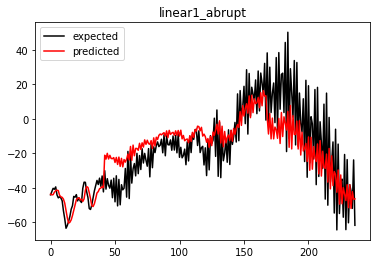

Time wasted: 0.00h
SMAPE: 0.1522


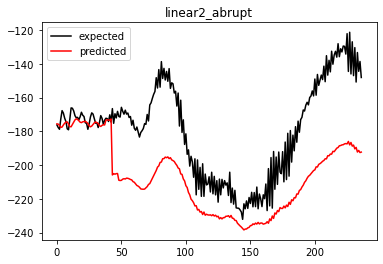

Time wasted: 0.00h
SMAPE: 0.6557


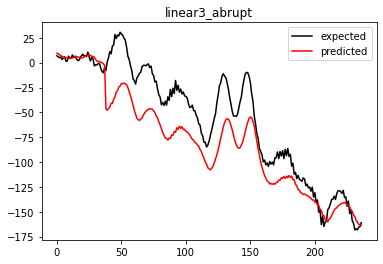

Time wasted: 0.00h
SMAPE: 1.2903


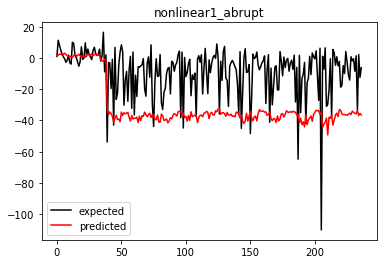

Time wasted: 0.00h
SMAPE: 1.1011


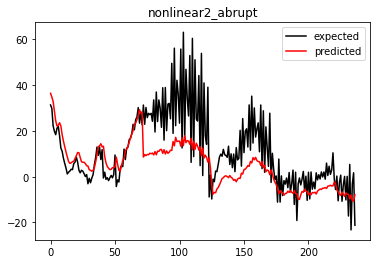

Time wasted: 0.00h
SMAPE: 1.8515


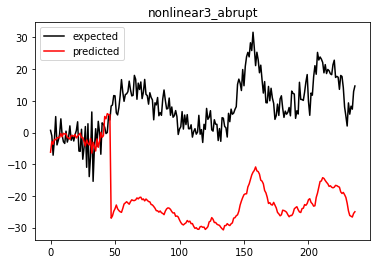

Time wasted: 0.00h
SMAPE: 0.7516


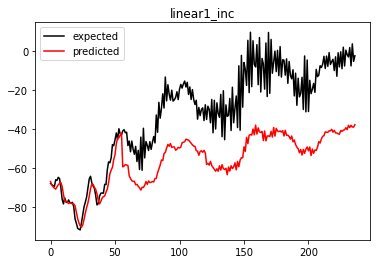

Time wasted: 0.00h
SMAPE: 0.9888


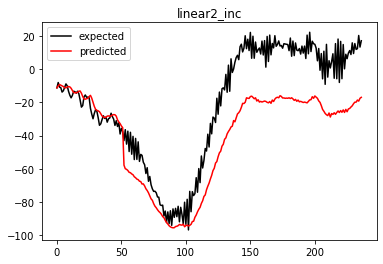

Time wasted: 0.00h
SMAPE: 0.2235


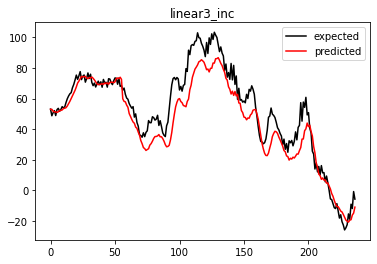

Time wasted: 0.00h
SMAPE: 1.5798


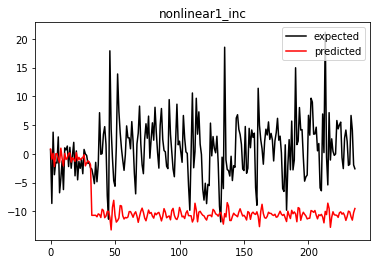

Time wasted: 0.00h
SMAPE: 0.4161


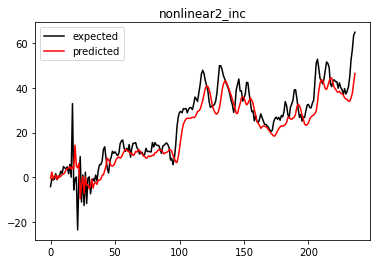

Time wasted: 0.00h
SMAPE: 1.1894


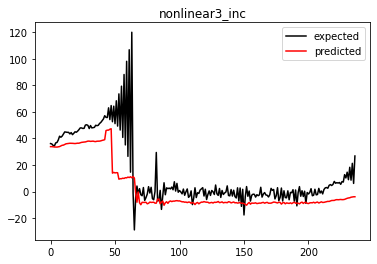

In [8]:
for name in list_of_names:
    file_path = "data/"+name
    data = pd.read_csv(file_path)

    #need this for error computation and plotting
    ground_truth = data.loc[int(0.7*len(data)):, "t"]

    train, test, scaler = preprocessing(data)
    train_X_input, train_X_aux, test_X_input, test_X_aux, train_y, test_y = forecast_preprocessing(train, test)
    
    start = time.perf_counter()
    model = fit_cond_rnn(train_X_input, train_X_aux, train_y)
    predictions = model.predict([test_X_input, test_X_aux])
    end = time.perf_counter()
    print("Time wasted: {:.2f}h".format((end-start)/3600))

    #inverting predictions to original scale
    predictions = scaler.inverse_transform(np.asarray(predictions).reshape([-1,1]))

    error = smape(predictions, ground_truth.reset_index(drop = True).values.reshape([-1,1]))
    smape_dict[name] = error
    print("SMAPE: {:.4f}".format(error))
    
    plt.plot(ground_truth.reset_index(drop = True), label = "expected", color = "black")
    plt.plot(predictions, label = "predicted", color = "red")
    plt.title(name)
    plt.legend()
    #saving the plot
    image_path = "forecasting_results/cond_rnn/"+name+".png"
    plt.savefig(image_path)
    
    plt.show()

#saving dictionary with SMAPE into txt
dict_path = "forecasting_results/cond_rnn/error.txt"
with open(dict_path, 'w') as file:
    file.write(json.dumps(smape_dict))